In [1]:
import torch
from torch import utils
import pandas as pd
import numpy as np
from pathlib import Path 
from matplotlib import pyplot as plt
from deep_cluster.dataloader import *
pd.set_option('mode.chained_assignment', None)

import os
import re
import numpy as np
import scipy.signal as sig
import pandas as pd

# root directory of data
data_root = Path("/home/orel/Storage/Data/K6/")
landmark_files = []
for subdir in os.listdir(data_root):
    for file in os.listdir(data_root/subdir/'Down'):
        if re.match(r"00\d*DeepCut_resnet50_Down2May25shuffle1_1030000\.h5", file):
            lfile = data_root/subdir/'Down'/file
            landmark_files.append(lfile)


In [70]:
def calc_wavelet_transform(feature_data, min_width=12, max_width=120, n_waves=25):
    wavelet_widths = np.logspace(np.log10(min_width), np.log10(max_width), n_waves)
    transformed = sig.cwt(feature_data, sig.morlet2, widths=wavelet_widths)
    transformed /= wavelet_widths[:,np.newaxis]
#     import pdb; pdb.set_trace()
    return np.abs(transformed)

omega0 = 5
min_width=1; max_width=120; n_waves=25;
wavelet_widths = np.logspace(np.log10(min_width), np.log10(max_width), n_waves)
wavelet_timescales = wavelet_widths / 60

wavelet_freqs = (omega0 + np.sqrt(2 + omega0**2)) / (4 * np.pi * wavelet_timescales)
T = 1000
sine_waves = np.exp(np.linspace(np.zeros_like(wavelet_freqs), 2j * T * np.pi * wavelet_freqs, 60*T))

transformed = np.stack([sig.cwt(sine_waves[:,i], sig.morlet2, widths=wavelet_widths[i:i+1]) for i in range(n_waves)])
c_s = (np.pi**(-1/4) / (np.sqrt(2 * wavelet_timescales)) ) * np.exp(0.25 / (omega0 + np.sqrt(2 + omega0**2))**2)
np.abs(transformed).mean(axis=(1,2)) * c_s

array([7.72718945, 7.72717247, 7.7271494 , 7.72711064, 7.72706956,
       7.72700539, 7.72694641, 7.72688387, 7.72678618, 7.72668073,
       7.72654188, 7.72637743, 7.72617509, 7.725929  , 7.7256271 ,
       7.72525982, 7.72481124, 7.7242646 , 7.72359579, 7.72277929,
       7.72178253, 7.72056543, 7.71907997, 7.7172671 , 7.71505341])

## TODO:  
Try using square root to normalize the wavelets, see hoe it affects  kurtosis and histogram.

In [12]:
def calc_wavelet_transform(feature_data, min_width=12, max_width=120, n_waves=25):
    wavelet_widths = np.logspace(np.log10(min_width), np.log10(max_width), n_waves)
    transformed = sig.cwt(feature_data, sig.morlet2, widths=wavelet_widths)
    transformed /= wavelet_widths[:,np.newaxis]
#     import pdb; pdb.set_trace()
    return np.abs(transformed)

# A dataset of landmarks
# args: landmarks file: .h5 file of landmarks, from DeepLabCut
class LandmarkWaveletDataset(utils.data.Dataset):
    def __init__(self, landmarks_file, normalize=True, data=None, eps=3e-2):
        super(LandmarkWaveletDataset, self).__init__()
        self.file = landmarks_file
        self.normalize = normalize
        self.landmarks = LandmarkDataset(self.file, normalize)
        if data is None:
            coords = sig.decimate(self.landmarks.coords, q=4, axis=0)
            coords = coords.reshape((len(coords), -1))
            self.data = [calc_wavelet_transform(feat_data, min_width=2, max_width=30, n_waves=20) for feat_data in coords.T]
            self.data = np.concatenate(self.data, axis=0).T
            self.data = np.sqrt(self.data)
#             self.data = np.log(self.data + eps) + 2
        else:
            self.data = data
        
    def __getitem__(self, idx):
        if isinstance(idx, slice):
            return LandmarkWaveletDataset(self.file, self.normalize, data=self.data[idx])
        return self.data[idx]
    
    def __len__(self):
        return self.data.shape[0]


In [20]:
ds.landmarks.coords.std(axis=0)

array([[2.96070349e+01, 1.27091150e-14],
       [3.18936761e+01, 1.83259078e+01],
       [1.94601573e+01, 2.49808903e+01],
       [1.95256253e+01, 2.51199788e+01],
       [1.69183580e+01, 2.39209000e+01],
       [9.31135934e+00, 1.67566166e+01],
       [1.65703344e+01, 1.92732473e+01],
       [1.66396645e+01, 2.04113432e+01],
       [0.00000000e+00, 0.00000000e+00],
       [5.43265460e+00, 6.39858507e+00],
       [5.62812044e+01, 4.11869272e+01],
       [1.04432578e+02, 6.23164439e+01]])

In [14]:
ds = LandmarkWaveletDataset(landmark_files[8])


> <ipython-input-12-93827dea23ca>(6)calc_wavelet_transform()
      4 #     transformed /= wavelet_widths[:,np.newaxis]
      5     import pdb; pdb.set_trace()
----> 6     return np.abs(transformed)
      7 
      8 # A dataset of landmarks



ipdb>  p transformed.shapoe


*** AttributeError: 'numpy.ndarray' object has no attribute 'shapoe'


ipdb>  p transformed.shape


(20, 128974)


ipdb>  p transformed.sum(axis=0)


array([ 92.20199985-1542.15295121j, 828.03804426-1057.49575629j,
       847.47031356 -540.92629755j, ..., 660.92665828 +285.34933643j,
       663.74811141 +525.5251756j , 570.66327081 +885.69465209j])


ipdb>  p np.aabs(transformed).sum(axis=0)


*** AttributeError: module 'numpy' has no attribute 'aabs'


ipdb>  p np.abs(transformed).sum(axis=0)


array([1608.5081679 , 1582.56371532, 1507.91693318, ..., 1108.31598546,
       1180.23818178, 1235.84741042])


ipdb>  p np.abs(transformed)[:,0]


array([ 50.85379627,  50.00314936,  52.55075829,  55.536457  ,
        58.31451996,  61.24946036,  62.97992319,  65.46384693,
        68.62487532,  73.6498383 ,  79.00434954,  85.55286957,
        94.51308067, 102.51553426, 106.47813686, 106.77829977,
       106.45186544, 106.78730321, 107.62350955, 113.57659405])


ipdb>  p np.abs(transformed),mean(axis=1)


*** NameError: name 'mean' is not defined


ipdb>  p np.abs(transformed).mean(axis=1)


array([0.21832394, 0.36783176, 0.53865298, 0.70494943, 0.85623222,
       1.00184742, 1.16553653, 1.34418028, 1.54383301, 1.76828846,
       2.02552351, 2.3335104 , 2.70549786, 3.1210953 , 3.6013605 ,
       4.20046831, 4.93138241, 5.79244585, 6.90232514, 8.29205426])


ipdb>  wavelet_widths[:,np.newaxis]


array([[ 2.        ],
       [ 2.30637295],
       [ 2.65967809],
       [ 3.0671048 ],
       [ 3.53694377],
       [ 4.07875572],
       [ 4.70356592],
       [ 5.4240886 ],
       [ 6.25498562],
       [ 7.21316481],
       [ 8.3181241 ],
       [ 9.5923482 ],
       [11.0617662 ],
       [12.75627917],
       [14.7103686 ],
       [16.9637981 ],
       [19.56242252],
       [22.55912106],
       [26.01487328],
       [30.        ]])


ipdb>  p np.abs(transformed).mean(axis=1) / wavelet_widths


array([0.10916197, 0.15948494, 0.20252563, 0.22984198, 0.24208251,
       0.24562575, 0.24779849, 0.2478168 , 0.2468164 , 0.24514738,
       0.24350725, 0.2432679 , 0.244581  , 0.24467129, 0.24481783,
       0.24761367, 0.25208444, 0.25676736, 0.26532227, 0.27640181])


ipdb>  p np.abs(transformed).mean(axis=1) / np.sqrt(wavelet_widths)


array([0.15437834, 0.24220575, 0.33028932, 0.40252574, 0.45527886,
       0.49606403, 0.53741808, 0.57715722, 0.61728705, 0.65840055,
       0.70230311, 0.75343757, 0.81345767, 0.87386636, 0.93897671,
       1.01984968, 1.11495506, 1.21955361, 1.35327032, 1.51391506])


ipdb>  q


BdbQuit: 

In [11]:
np.prod(dsets[0].data.shape) * 4 * 12

2856107520

In [1]:
ds1 = utils.data.ConcatDataset([ds[:1000], ds[10000:11000]])

NameError: name 'utils' is not defined

In [96]:
ds.data[ds.data > ds.data.min() + 1e-3].mean()

-1.8518811694883994

In [95]:
ds.data.min(), np.exp(3e-2)

(-3.506557897319982, 1.030454533953517)

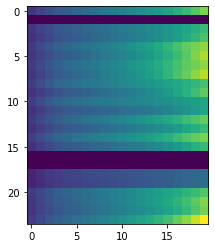

In [5]:
plt.imshow(ds.data.mean(axis=0).reshape(24, 20))

1.2135759579664385

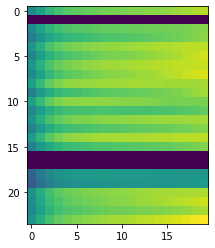

In [78]:
plt.imshow(ds.data.mean(axis=0).reshape(24, 20))
ds.data.std()

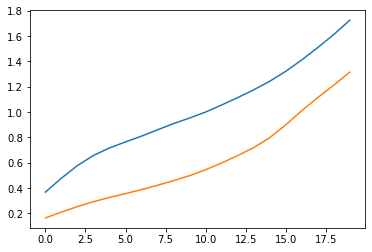

In [6]:
plt.plot(ds.data.mean(axis=0).reshape(24, 20).mean(axis=0))
plt.plot(ds.data.std(axis=0).reshape(24, 20).mean(axis=0))

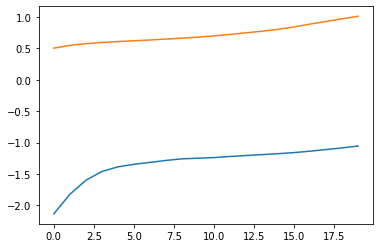

In [79]:
plt.plot(ds.data.mean(axis=0).reshape(24, 20).mean(axis=0))
plt.plot(ds.data.std(axis=0).reshape(24, 20).mean(axis=0))

1

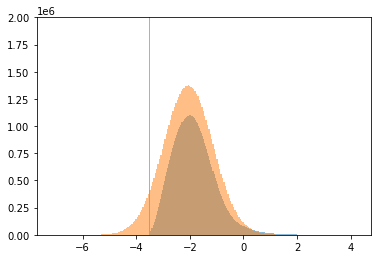

In [83]:
lg = False
plt.hist(ds.data.flatten(), bins=200, log=lg, alpha=0.5)
# plt.hist(np.random.laplace(loc=data.mean(), scale=np.abs(data-data.mean()).mean(), size=len(data.flatten())), log=lg, alpha=0.5, bins=200)
plt.hist(np.random.normal(loc=ds.data.mean(), scale=ds.data.std(), size=len(ds.data.flatten())), log=lg, alpha=0.5, bins=200)
plt.ylim((0, 2e6))
1

1

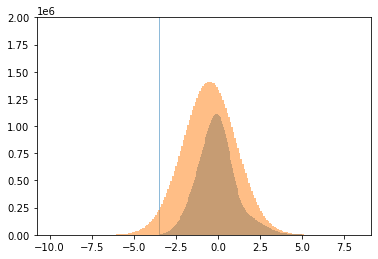

In [69]:
lg = False
plt.hist(ds.data.flatten(), bins=200, log=lg, alpha=0.5)
# plt.hist(np.random.laplace(loc=data.mean(), scale=np.abs(data-data.mean()).mean(), size=len(data.flatten())), log=lg, alpha=0.5, bins=200)
plt.hist(np.random.normal(loc=ds.data.mean(), scale=ds.data.std(), size=len(ds.data.flatten())), log=lg, alpha=0.5, bins=200)
plt.ylim((0, 2e6))
1

In [29]:
data.mean()

-1.7774274779722163e-08

1

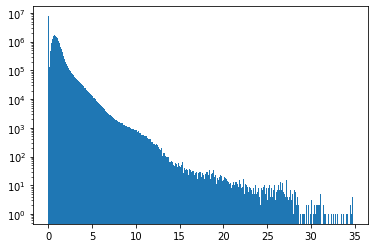

In [11]:
plt.hist(ds.data.flatten(), bins=1000, log=True)
1

(-2.364163833753029, 1.211087216369255)

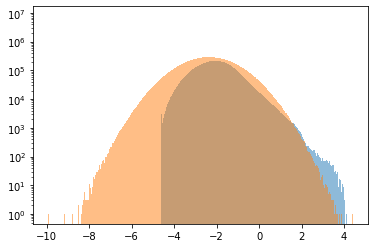

In [57]:
eps = 1e-2
log_data = np.log(ds.data[ds.data>-eps].flatten() + eps)
plt.hist(log_data, bins=1000, log=True, alpha=0.5)
plt.hist(np.random.normal(loc=log_data.mean(), scale=log_data.std(), size=len(log_data)), bins=1000, log=True, alpha=0.5)
log_data.mean(), log_data.std()

In [ ]:
log_data.min()

In [147]:
np.log(ds.data[ds.data>eps].flatten() + eps).mean(), np.log(ds.data[ds.data>eps].flatten() + eps).std()

(-0.05576794733710523, 1.2547144081463357)

1

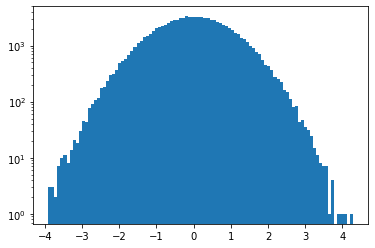

In [134]:
plt.hist(np.random.normal(size=100000), bins=100, log=True)
1

In [2]:
data_path = Path('/home/orel/Data/K6/2020-03-30/Down/')
landmarks_file = data_path / '0014DeepCut_resnet50_DownMay7shuffle1_1030000.h5'

In [3]:
def extract_coords(landmarks_file):
    df = read_df(landmarks_file)
    return pd.unique([col[0] for col in df.columns])


extract_coords(landmarks_file)

array(['nose', 'neck', 'forepawR', 'forePawL', 'chest', 'belly',
       'hindpawR', 'hindpawL', 'tailbase', 'tail1', 'tail2', 'tail3'],
      dtype=object)

In [10]:
extract_coords(landmark_files[2])

array(['nose', 'neck', 'forepawR', 'forePawL', 'chest', 'belly',
       'hindpawR', 'hindpawL', 'tailbase', 'tail1', 'tail2', 'tail3'],
      dtype=object)